In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime
from single_data_processing import SingleAssetTI

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


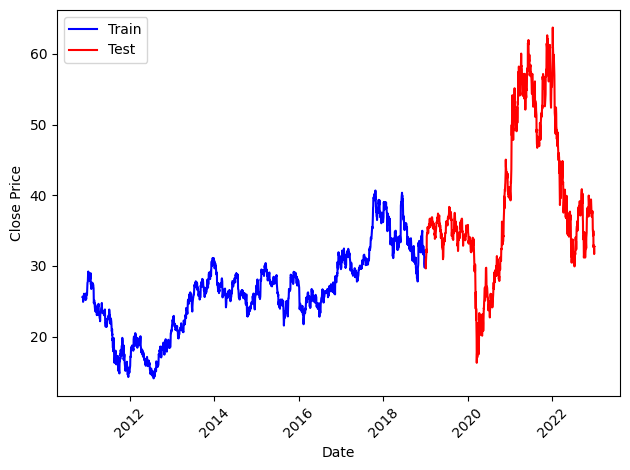

In [2]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
ticker = 'GM'
data = SingleAssetTI(ticker, start_date, end_date,2019)
data.data_preprocess()
train_data = data.train_data    
val_data = data.test_data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

evolve_strategy = ["ring", "multikuti", "master_slave", "nearest","random","fully_connected"]
num_runs = 10
all_records = []

for strategy in evolve_strategy:
    if strategy == 'gga':
        num_islands = 1
        pop_size = 150
    else:
        num_islands = 5
        pop_size = 150

    for run in range(num_runs):

        
        ga = IslandGGA(
            data=data.train_data,
            K=2,
            num_islands=num_islands,
            m_iter=3,
            num_iter=30,
            pSize=pop_size,
            strategies=data.strategies,
            evolve_strategy=strategy
        )
        ga.evolve()
        convergence = ga.convergence_times  # assume it's a list of values over time

        for t, val in enumerate(convergence, start=1):
            all_records.append({
                'strategy': strategy,
                'run': run,
                'iteration': t,
                'value': val
            })

# Convert to DataFrame
df_convergence = pd.DataFrame(all_records)

# Save for inspection
df_convergence.to_csv("results/convergence_time.csv", index=False)


Running ring
Generation 1: Best fitness = 1.2599644038621738  Average Fitness = 1.2487656451696207
Generation 2: Best fitness = 1.2599644038621738  Average Fitness = 1.2577246521236627
Generation 3: Best fitness = 1.2599644038621738  Average Fitness = 1.2599644038621733
Island 0 Migration - Left 4 - Right 1
Island 1 Migration - Left 0 - Right 2
Island 2 Migration - Left 1 - Right 3
Island 3 Migration - Left 2 - Right 4
Island 4 Migration - Left 3 - Right 0
Generation 4: Best fitness = 1.2599644038621738  Average Fitness = 1.2599644038621733
Generation 5: Best fitness = 1.2599644038621738  Average Fitness = 1.2588445279929181
Generation 6: Best fitness = 1.2599644038621738  Average Fitness = 1.2599644038621733
Island 0 Migration - Left 4 - Right 1
Island 1 Migration - Left 0 - Right 2
Island 2 Migration - Left 1 - Right 3
Island 3 Migration - Left 2 - Right 4
Island 4 Migration - Left 3 - Right 0
Generation 7: Best fitness = 1.2599644038621738  Average Fitness = 1.256542755853095
Genera

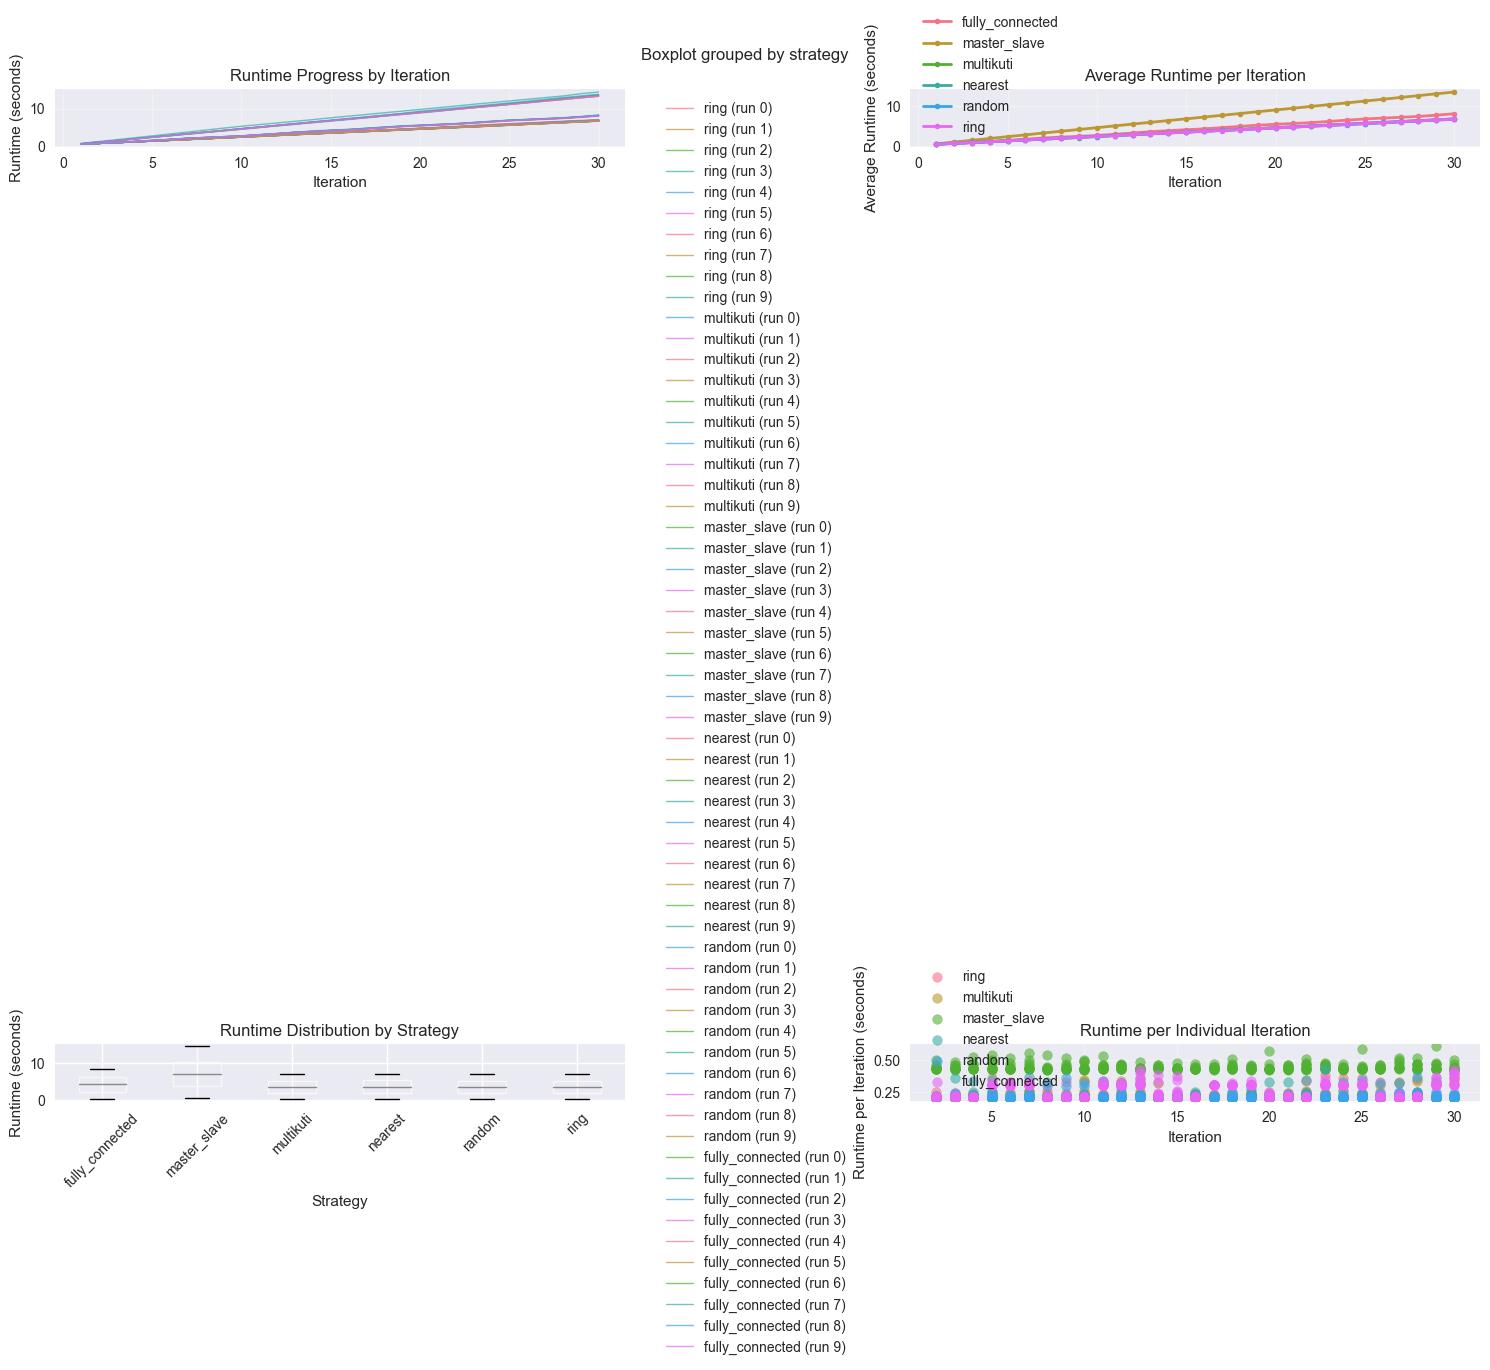

=== Runtime Summary Statistics ===
                 count      mean       std       min       25%       50%  \
strategy                                                                   
fully_connected  300.0  4.255344  2.293820  0.493224  2.273549  4.252860   
master_slave     300.0  7.093301  3.884544  0.558662  3.716814  7.135499   
multikuti        300.0  3.643082  1.897718  0.493770  1.970803  3.650999   
nearest          300.0  3.683412  1.900079  0.488705  2.091049  3.649577   
random           300.0  3.617423  1.868753  0.490163  1.959273  3.666096   
ring             300.0  3.636313  1.876432  0.492934  2.026937  3.647644   

                       75%        max  
strategy                               
fully_connected   6.216509   8.290203  
master_slave     10.386851  14.445671  
multikuti         5.270161   6.918018  
nearest           5.326658   7.068661  
random            5.200742   6.947594  
ring              5.218095   6.954691  

=== Performance Analysis ===
Final 

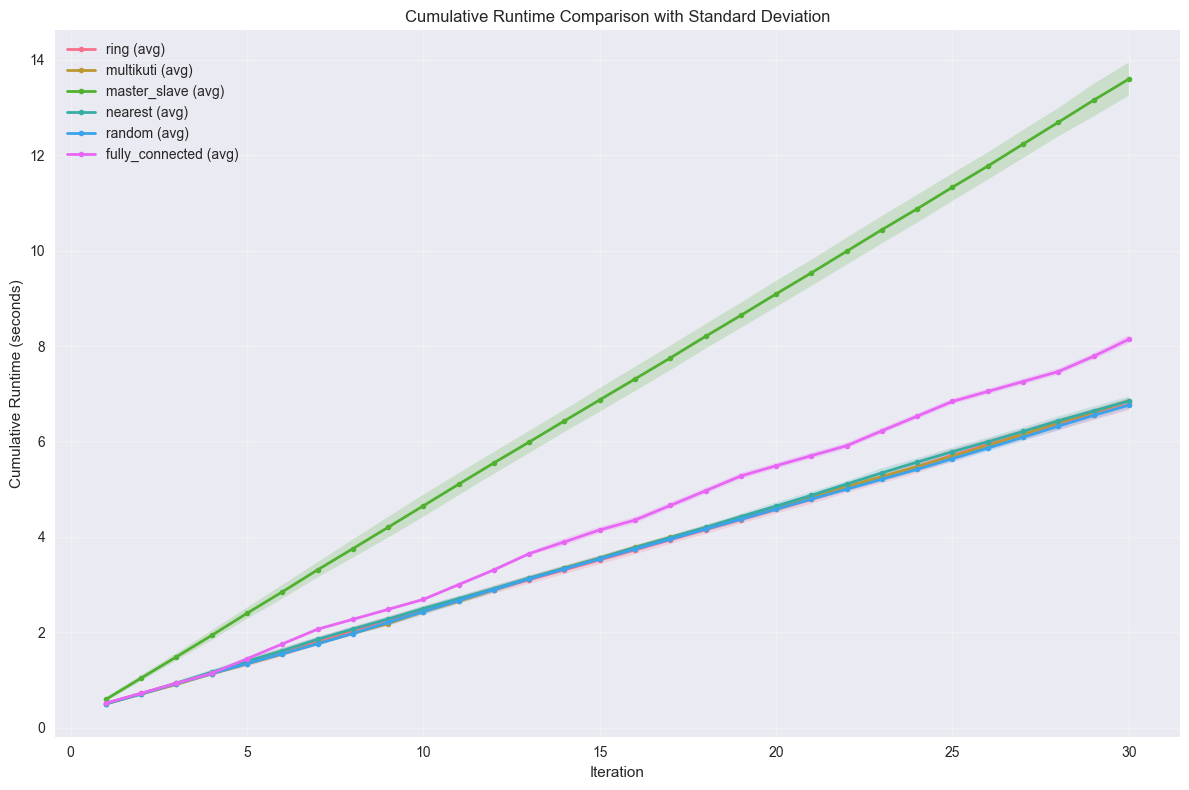

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the data
# Assuming your data is in a CSV file named 'runtime_data.csv'
df =pd.read_csv("results/convergence_time.csv")


# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Runtime Analysis by Strategy', fontsize=16, fontweight='bold')

# Plot 1: Runtime vs Iteration for each strategy (line plot)
ax1 = axes[0, 0]
for strategy in df['strategy'].unique():
    strategy_data = df[df['strategy'] == strategy]
    for run in strategy_data['run'].unique():
        run_data = strategy_data[strategy_data['run'] == run]
        ax1.plot(run_data['iteration'], run_data['value'], 
                alpha=0.7, linewidth=1, label=f'{strategy} (run {run})')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime Progress by Iteration')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Average runtime per iteration across all runs
ax2 = axes[0, 1]
avg_runtime = df.groupby(['strategy', 'iteration'])['value'].mean().reset_index()
for strategy in avg_runtime['strategy'].unique():
    strategy_avg = avg_runtime[avg_runtime['strategy'] == strategy]
    ax2.plot(strategy_avg['iteration'], strategy_avg['value'], 
             marker='o', linewidth=2, markersize=4, label=strategy)

ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Runtime (seconds)')
ax2.set_title('Average Runtime per Iteration')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Box plot of runtime distribution by strategy
ax3 = axes[1, 0]
df.boxplot(column='value', by='strategy', ax=ax3)
ax3.set_xlabel('Strategy')
ax3.set_ylabel('Runtime (seconds)')
ax3.set_title('Runtime Distribution by Strategy')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Plot 4: Runtime per iteration (showing trend)
ax4 = axes[1, 1]
for strategy in df['strategy'].unique():
    strategy_data = df[df['strategy'] == strategy]
    # Calculate runtime per iteration (difference between consecutive values)
    runtime_per_iter = []
    iterations = []
    
    for run in strategy_data['run'].unique():
        run_data = strategy_data[strategy_data['run'] == run].sort_values('iteration')
        if len(run_data) > 1:
            diffs = run_data['value'].diff().dropna()
            runtime_per_iter.extend(diffs.values)
            iterations.extend(run_data['iteration'].iloc[1:].values)
    
    if runtime_per_iter:
        ax4.scatter(iterations, runtime_per_iter, alpha=0.6, label=strategy)

ax4.set_xlabel('Iteration')
ax4.set_ylabel('Runtime per Iteration (seconds)')
ax4.set_title('Runtime per Individual Iteration')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== Runtime Summary Statistics ===")
print(df.groupby('strategy')['value'].describe())

# Calculate and print performance metrics
print("\n=== Performance Analysis ===")
final_runtimes = df.loc[df.groupby(['strategy', 'run'])['iteration'].idxmax()]
print("Final runtimes by strategy and run:")
print(final_runtimes[['strategy', 'run', 'value']])

print("\nAverage final runtime by strategy:")
avg_final = final_runtimes.groupby('strategy')['value'].agg(['mean', 'std'])
print(avg_final)

# Calculate average time per iteration
print("\nAverage time per iteration:")
for strategy in df['strategy'].unique():
    strategy_data = df[df['strategy'] == strategy]
    avg_time_per_iter = []
    
    for run in strategy_data['run'].unique():
        run_data = strategy_data[strategy_data['run'] == run].sort_values('iteration')
        if len(run_data) > 1:
            total_time = run_data['value'].iloc[-1] - run_data['value'].iloc[0]
            num_iterations = run_data['iteration'].iloc[-1] - run_data['iteration'].iloc[0]
            avg_time_per_iter.append(total_time / num_iterations)
    
    if avg_time_per_iter:
        print(f"{strategy}: {np.mean(avg_time_per_iter):.4f} ± {np.std(avg_time_per_iter):.4f} seconds/iteration")

# Create a separate plot for cumulative runtime comparison
plt.figure(figsize=(12, 8))
for strategy in df['strategy'].unique():
    strategy_data = df[df['strategy'] == strategy]
    avg_runtime = strategy_data.groupby('iteration')['value'].mean()
    std_runtime = strategy_data.groupby('iteration')['value'].std()
    
    plt.plot(avg_runtime.index, avg_runtime.values, 
             marker='o', linewidth=2, markersize=4, label=f'{strategy} (avg)')
    plt.fill_between(avg_runtime.index, 
                     avg_runtime.values - std_runtime.values,
                     avg_runtime.values + std_runtime.values,
                     alpha=0.2)

plt.xlabel('Iteration')
plt.ylabel('Cumulative Runtime (seconds)')
plt.title('Cumulative Runtime Comparison with Standard Deviation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()